In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap

In [2]:
def read_excel_sheets_to_np_arrays(file_path):
    """
    Reads all sheets from an Excel file and converts them to numpy arrays.

    Parameters:
    - file_path (str): The path to the Excel file.

    Returns:
    - dict: A dictionary where keys are sheet names and values are the corresponding numpy arrays.
    """
    # Load the Excel file
    xls = pd.ExcelFile(file_path)
    
    # Initialize an empty dictionary to store numpy arrays
    sheets_np = {}
    
    # Iterate over all sheet names
    for sheet_name in xls.sheet_names:
        # Read the current sheet to a pandas DataFrame
        df = pd.read_excel(xls, sheet_name=sheet_name, header=None)
        # Convert the DataFrame to a numpy array and store it in the dictionary
        sheets_np[sheet_name] = df.to_numpy()
    
    return sheets_np


In [3]:
def plot_network_from_matrix(adj_matrix, plot_only_connected_nodes=False, title='Network Graph', node_weights=None):
    """
    Plots a network graph from a given adjacency matrix where each row and column
    represents a node, and a '1' in the matrix indicates an interaction (edge)
    between the corresponding nodes.

    Parameters:
    - adj_matrix (np.array): A binary (0 or 1) 2D numpy array representing the adjacency matrix of the graph.
    - plot_only_connected_nodes (bool): If True, only nodes with at least one edge are plotted.
    """
    # Create a graph
    G = nx.from_numpy_array(adj_matrix)

    # Optional: Remove isolated nodes if the flag is True
    if plot_only_connected_nodes:
        G.remove_nodes_from(list(nx.isolates(G)))

    # Prepare the node colors based on weights using a colormap
    if node_weights is not None:
        if len(node_weights) != len(G.nodes):
            raise ValueError("The number of node weights must match the number of nodes in the graph.")
        node_color = node_weights
        cmap = plt.cm.magma  
        vmin = min(node_weights)
        vmax = max(node_weights)
    else:
        node_color = '#1f78b4'  # Default color if no weights are given
        cmap = None
        vmin = None
        vmax = None

    # Draw the graph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.27)  # positions for all nodes
    nx.draw_networkx_nodes(G, pos, node_size=20, cmap=cmap, node_color=node_color, vmin=vmin, vmax=vmax)
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)

    # If a colormap is used, add a colorbar
    if cmap:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        plt.colorbar(sm, label='Node Weights')
    
    plt.title(title)
    plt.axis('off')  # Turn off the axis
    plt.show()

In [4]:
def adjacency_matrix_to_list_and_save(matrix, filename="adjacency_list.csv", students_file="students_list.csv"):
    """
    Converts an adjacency matrix to an adjacency list format and saves it to a CSV file.
    Also creates a separate CSV file listing all students (nodes) by index.

    Parameters:
    - matrix (np.array): A numpy array representing the adjacency matrix.
    - filename (str): The name of the file to save the adjacency list to.
    - students_file (str): The name of the file to list all students' indices.
    """
    # Number of nodes
    num_nodes = matrix.shape[0]

    # Create adjacency list
    adjacency_list = []
    for i in range(num_nodes):
        # Find indices of adjacent nodes
        adjacent_nodes = np.where(matrix[i] == 1)[0]
        for j in adjacent_nodes:
            adjacency_list.append([i, j])

    # Write to CSV file for adjacency list
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Source', 'Target'])  # Header
        writer.writerows(adjacency_list)

    print(f"Adjacency list saved to {filename}")

    # Create list of student indices
    students_indices = [[i] for i in range(num_nodes)]

    # Write to CSV file for student indices
    with open(students_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Students'])  # Header
        writer.writerows(students_indices)

    print(f"Students list saved to {students_file}")

In [5]:
def network_analysis_with_gpa(adj_matrix, gpas):
    """
    Performs a comprehensive network analysis on the given adjacency matrix, integrating student GPA data.

    Parameters:
    - adj_matrix (np.array): A numpy 2D array representing the binary adjacency matrix of the graph.
    - gpas (list or np.array): A list or array of GPA scores for each student (node) in the network.

    Returns:
    - report_df: A pandas dataframe containing various network metrics and their values, including GPA-related analyses.
    """
    # Create the graph from the adjacency matrix
    G = nx.from_numpy_array(adj_matrix)

    # Compute various centrality measures
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
    clustering_coefficient = nx.clustering(G)

    # Compute GPA-weighted Degree Centrality
    gpa_weighted_degree = {node: degree_centrality[node] * gpas[node] for node in G.nodes}

    # Correlations between GPA and centrality measures
    df = pd.DataFrame({
        'GPA': gpas,
        'Degree Centrality': list(degree_centrality.values()),
        'Closeness Centrality': list(closeness_centrality.values()),
        'Betweenness Centrality': list(betweenness_centrality.values()),
        'Eigenvector Centrality': list(eigenvector_centrality.values())
    })
    correlations = df.corr().loc['GPA']

    # Plot GPA distribution across connected components and distribution of components across GPA
    component_gp_avg = {}
    component_names = []
    avg_gpas = []
    component_sizes = []  # To store the size of each component
    for component in nx.connected_components(G):
        component_gpas = [gpas[node] for node in component]
        avg_gpa = np.mean(component_gpas)
        component_name = f"Component_{min(component)}"
        component_gp_avg[component_name] = avg_gpa
        component_names.append(component_name)
        avg_gpas.append(avg_gpa)
        component_sizes.append(len(component))  # Store the size of the component

    # Plot for Average GPA Distribution Across Connected Components
    plt.figure(figsize=(10, 6))
    plt.bar(component_names, avg_gpas, color='skyblue')
    plt.xlabel('Components')
    plt.ylabel('Average GPA')
    plt.title('Average GPA Distribution Across Connected Components')
    plt.xticks(ticks=[], labels=[])  # No x labels for each component, only x label name
    plt.tight_layout()
    plt.show()

    # Plot for Distribution of Components Across GPA
    plt.figure(figsize=(10, 6))
    plt.scatter(avg_gpas, component_sizes, color='lightgreen')
    plt.xlabel('Average GPA')
    plt.ylabel('Component Size')
    plt.title('Distribution of Components Across GPA')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot GPA vs. clustering coefficient
    plt.figure()
    plt.scatter(list(clustering_coefficient.values()), gpas, alpha=0.7)
    plt.title('GPA vs. Clustering Coefficient')
    plt.xlabel('Clustering Coefficient')
    plt.ylabel('GPA')
    plt.grid(True)
    plt.show()

    # Plot GPA vs. centrality measures
    centrality_measures = ['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality', 'Eigenvector Centrality']
    for centrality in centrality_measures:
        plt.figure()
        plt.scatter(df[centrality], df['GPA'], alpha=0.7)
        plt.title(f'GPA vs. {centrality}')
        plt.xlabel(centrality)
        plt.ylabel('GPA')
        plt.grid(True)
        plt.show()
        
    # Assemble the report as a pandas DataFrame
    report_df = pd.DataFrame({
        'GPA': gpas,
        'Degree Centrality': list(degree_centrality.values()),
        'Closeness Centrality': list(closeness_centrality.values()),
        'Betweenness Centrality': list(betweenness_centrality.values()),
        'Eigenvector Centrality': list(eigenvector_centrality.values()),
        'Clustering Coefficient': list(clustering_coefficient.values()),
        'GPA-Weighted Degree Centrality': list(gpa_weighted_degree.values()),
        # 'Correlations between GPA and Centralities': correlations.tolist(),
        # 'GPA by Component': list(component_gp_avg.values())
    }, index=list(degree_centrality.keys()))

    return report_df

In [6]:
# Extract the numpy arrays from the Excel file
networks_school_np = read_excel_sheets_to_np_arrays('networks_school.xlsx')
# Accessing the numpy arrays can be done by sheets_np['Sheet1'], sheets_np['Sheet2'], etc.

In [ ]:
plot_network_from_matrix(networks_school_np['Sheet1'], plot_only_connected_nodes=True, title='Network Graph of School at Time 1')
plot_network_from_matrix(networks_school_np['Sheet2'], plot_only_connected_nodes=True, title='Network Graph of School at Time 2')
plot_network_from_matrix(networks_school_np['Sheet2'], plot_only_connected_nodes=True, title='Network Graph of School at Time 3')
plot_network_from_matrix(networks_school_np['Sheet2'], plot_only_connected_nodes=True, title='Network Graph of School at Time 4')
plot_network_from_matrix(networks_school_np['Sheet2'], plot_only_connected_nodes=True, title='Network Graph of School at Time 5')
plot_network_from_matrix(networks_school_np['Sheet2'], plot_only_connected_nodes=True, title='Network Graph of School at Time 6')

In [7]:
adjacency_matrix_to_list_and_save(networks_school_np['Sheet1'], filename="adjacency_list.csv", students_file="students_list.csv")

Adjacency list saved to adjacency_list.csv
Students list saved to students_list.csv


Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


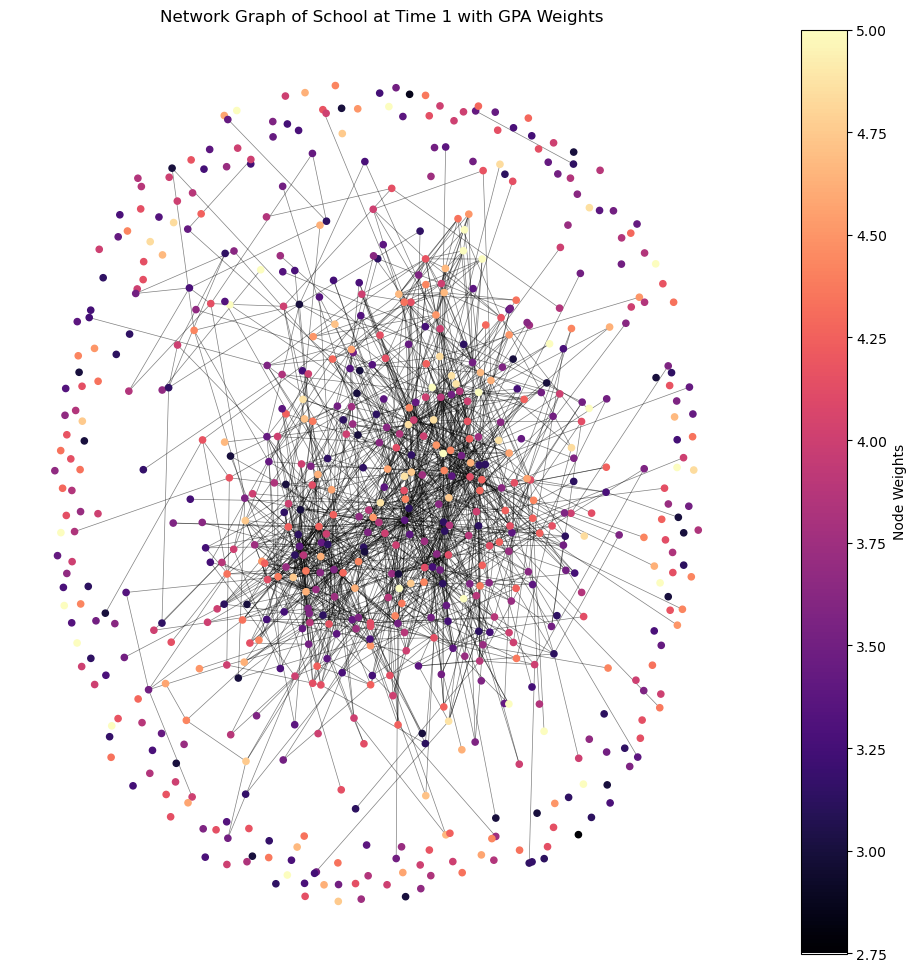

In [8]:
# Load the gpa data
gpa_data = pd.read_excel('gpa_school.xlsx', header=None)

# Get first column of gpa data (Time 1)
gpa_data_1 = gpa_data[0].to_numpy()

# Plot network graph with gpa weights
plot_network_from_matrix(networks_school_np['Sheet1'], plot_only_connected_nodes=False, title='Network Graph of School at Time 1 with GPA Weights', node_weights=gpa_data_1)

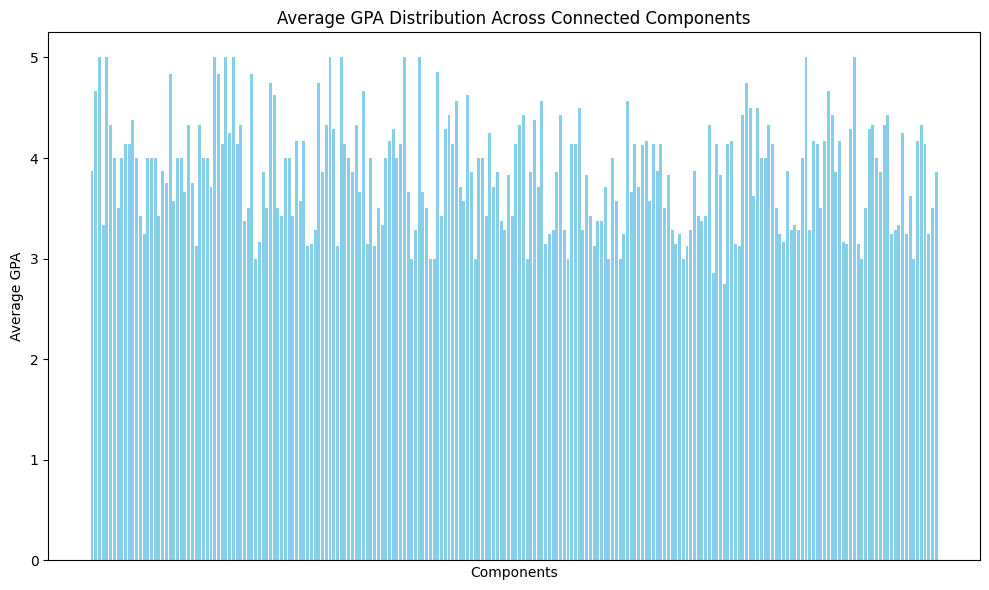

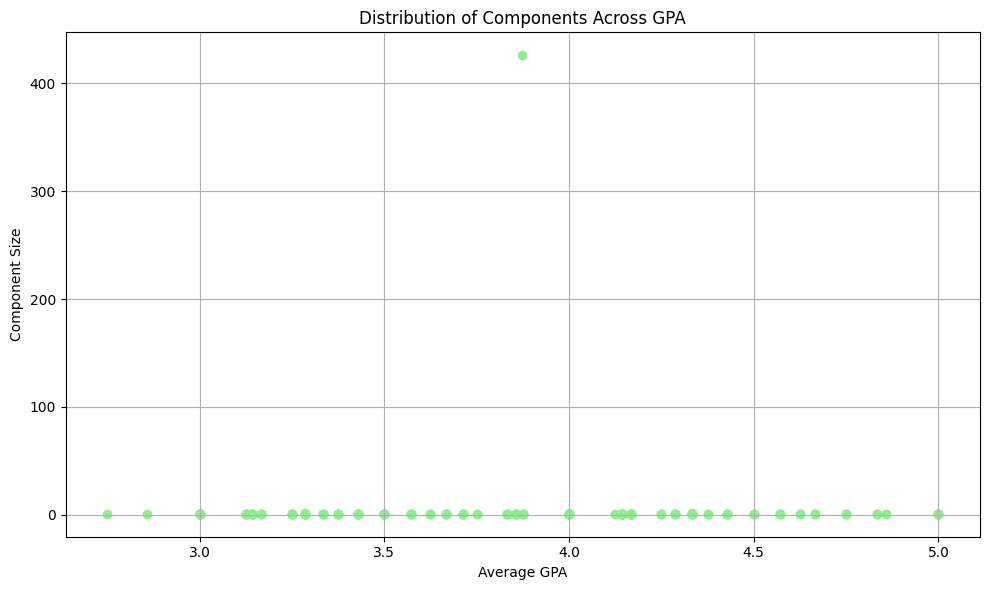

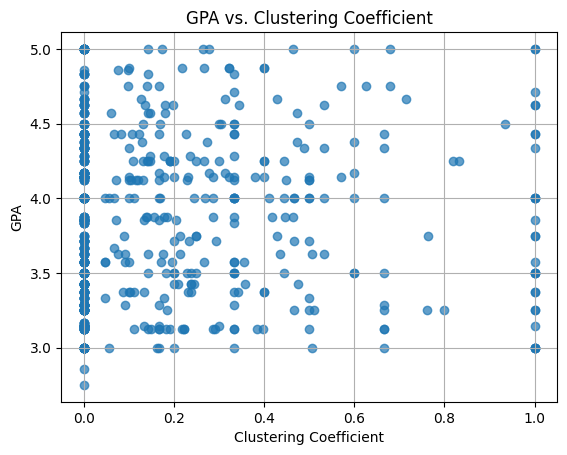

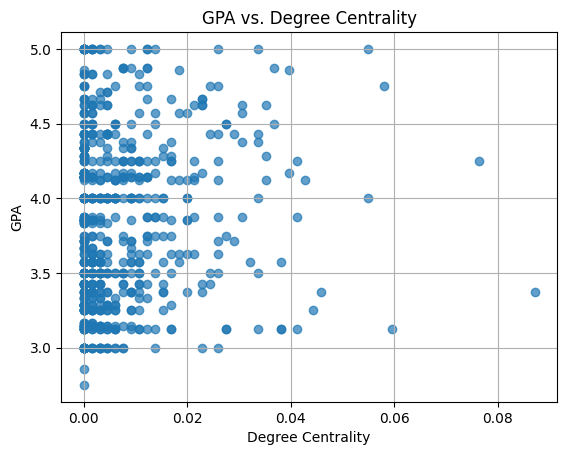

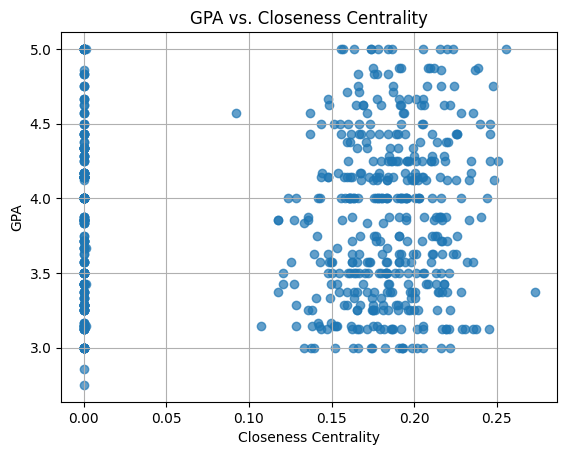

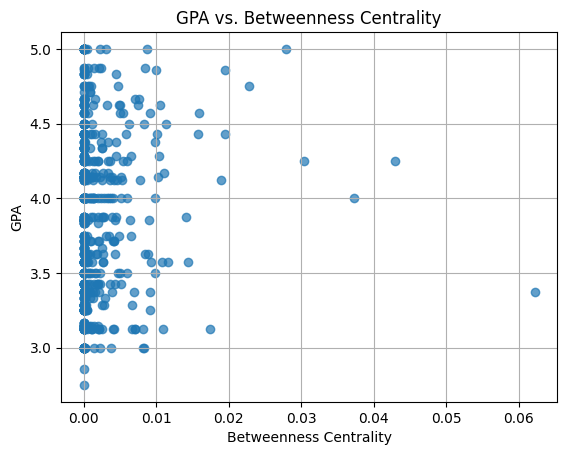

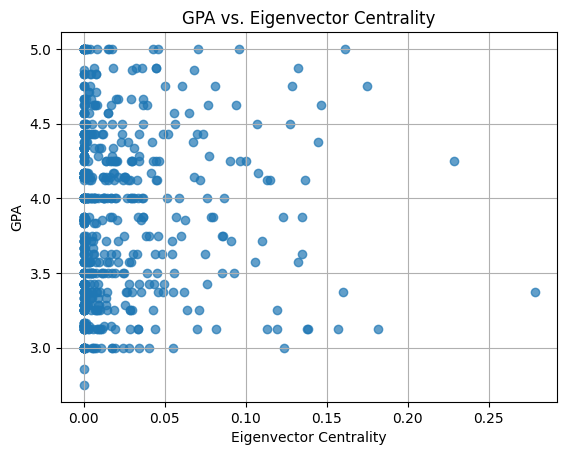

In [171]:
networks_school_report = network_analysis_with_gpa(networks_school_np['Sheet1'], gpa_data_1)

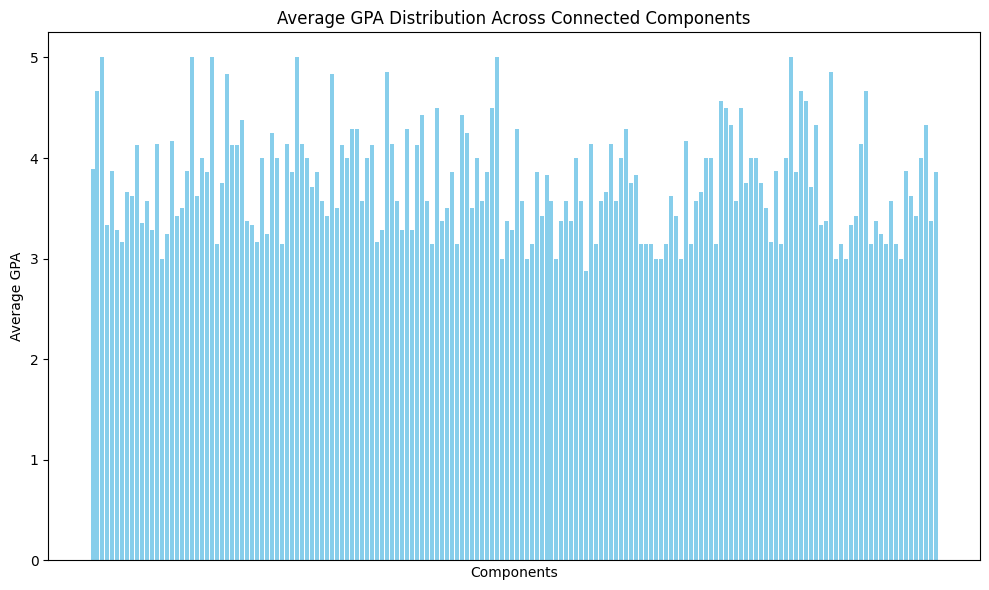

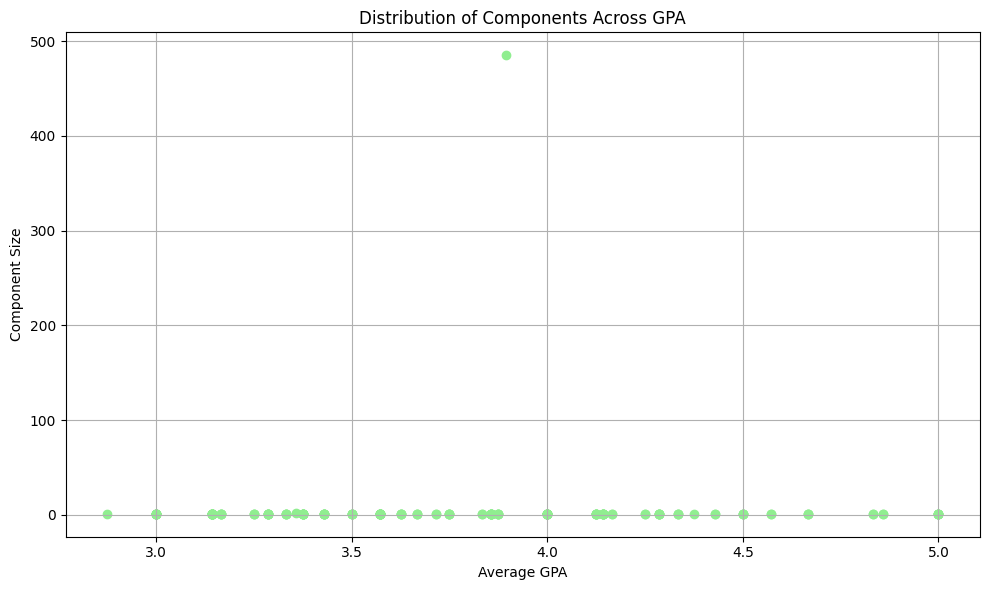

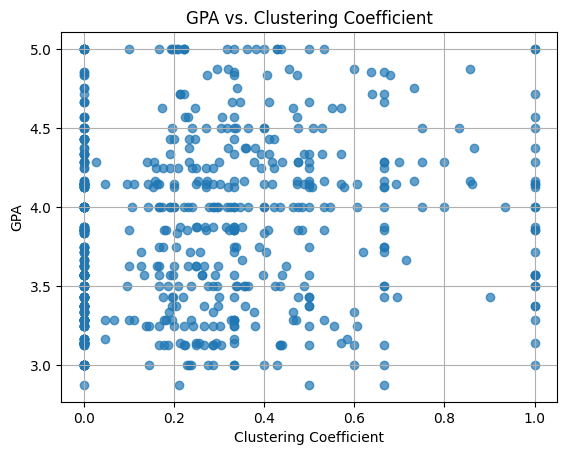

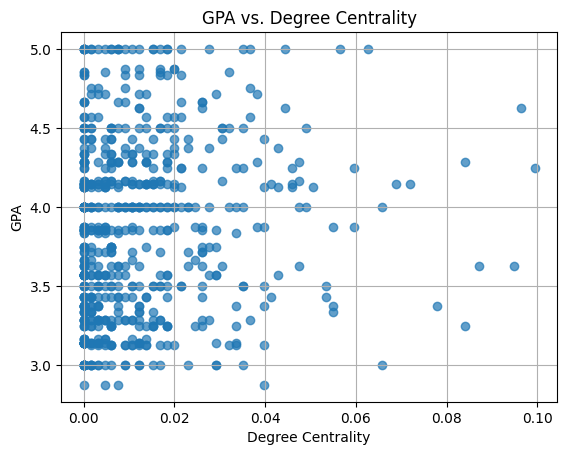

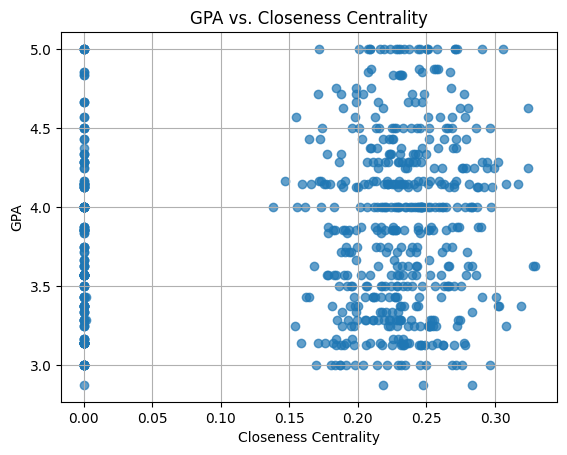

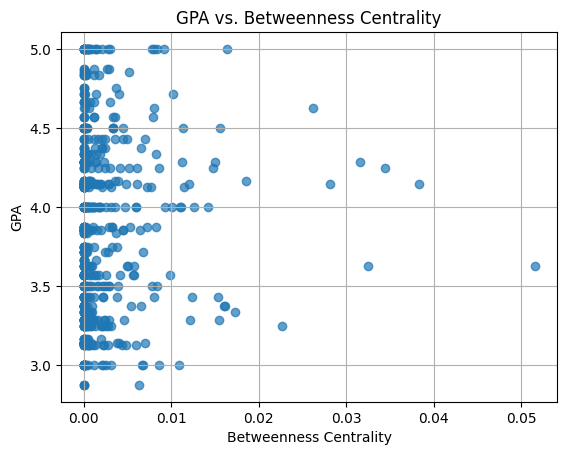

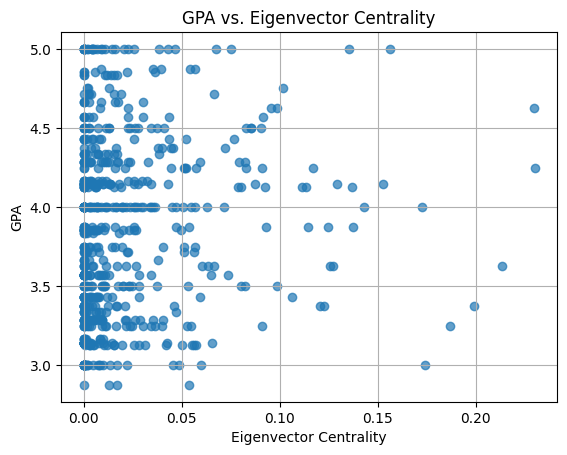

In [172]:
# Get gpa data from Time 6
gpa_data_6 = gpa_data[5].to_numpy()

networks_school_report = network_analysis_with_gpa(networks_school_np['Sheet6'], gpa_data_6)

In [167]:
G = nx.from_numpy_array(networks_school_np['Sheet1'], create_using=nx.DiGraph)
reciprocity = nx.reciprocity(G)
print(f"Reciprocity: {reciprocity}")

Reciprocity: 0.21399652978600348


Mean Squared Error: 0.29804899601786305
Feature Importances:
Closeness Centrality: 0.3049681669846453
Eigenvector Centrality: 0.2698202451456989
Betweenness Centrality: 0.21242823848190057
Clustering Coefficient: 0.13382324132170154
Degree Centrality: 0.07896010806605379


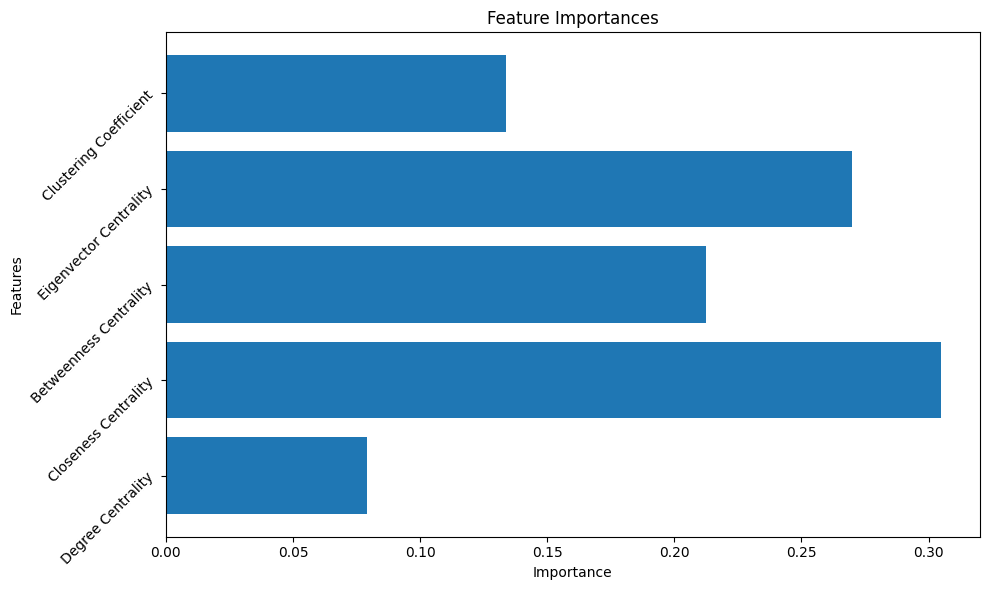

In [154]:
# Prepare the data
X = networks_school_report.drop(columns=['GPA', 'GPA-Weighted Degree Centrality'], axis=1)
y = networks_school_report['GPA']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Feature importance
feature_importances = rf.feature_importances_
importance_dict = dict(zip(X.columns, feature_importances))
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")

# Plot the feature importances in a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, tick_label=X.columns)
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

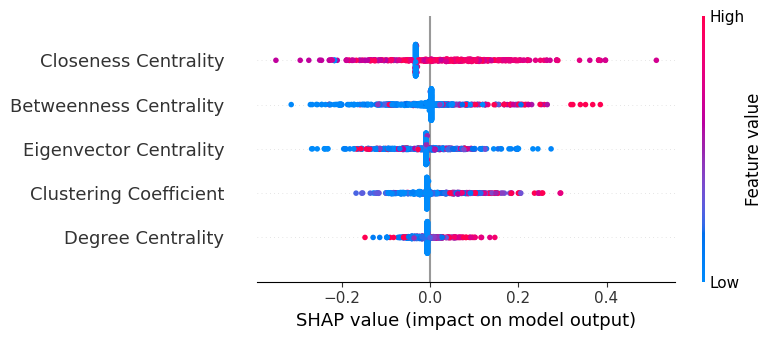

In [155]:
# Plot SHAP values

# Create an explainer object
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values
shap_values = explainer.shap_values(X)

# Summary plot with color
shap.summary_plot(shap_values, X, plot_type="dot")

# Force plot
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X, link="logit", matplotlib=False)

Category counts: [166 162 171 156]
Probability of mixed edges: 0.7496299749431851
Category counts: [174 156 179 146]
Probability of mixed edges: 0.7496299749431851
Category counts: [178 154 163 160]
Probability of mixed edges: 0.7496299749431851
Category counts: [178 154 163 160]
Probability of mixed edges: 0.7496299749431851
Category counts: [173 166 157 159]
Probability of mixed edges: 0.7496299749431851
Category counts: [173 166 157 159]
Probability of mixed edges: 0.7496299749431851


Text(0, 0.5, 'Pearson Correlation Coefficient')

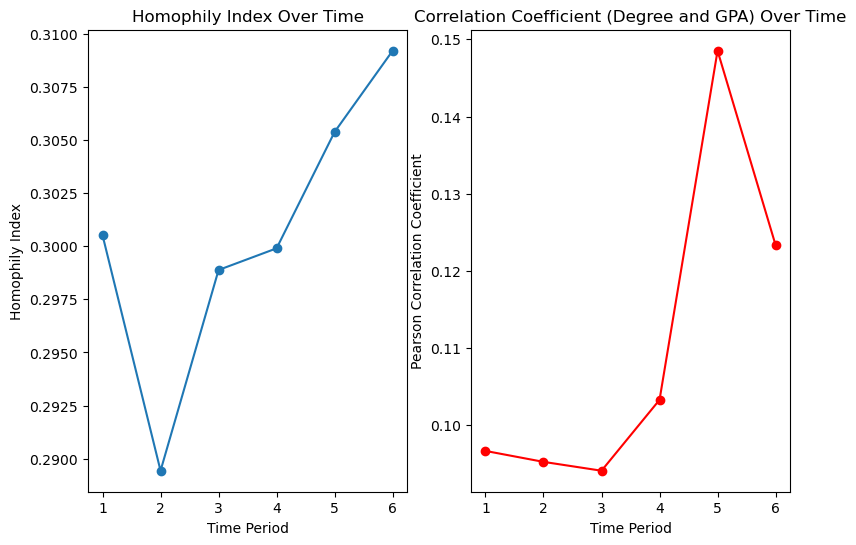

In [41]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, chi2_contingency

# Function to calculate homophily index
def calculate_homophily(graph, node_attributes):
    same_attr_edges = 0
    total_edges = 0
    for edge in graph.edges():
        if node_attributes[edge[0]] == node_attributes[edge[1]]:
            same_attr_edges += 1
        total_edges += 1
    if total_edges > 0:
        return same_attr_edges / total_edges
    else:
        return 0

# Initialize lists to store results
homophily_indices = []
correlation_coefficients = []
chi_squared_stats = []
p_values = []
homophily = []  # To store mixed edge probabilities

# Load GPA data
gpa_data_all = pd.read_excel('gpa_school.xlsx', header=None)

# Loop through each sheet/time period
for i in range(1, 7):
    sheet_name = f'Sheet{i}'
    adjacency_matrix = networks_school_np[sheet_name]
    gpa_data = gpa_data_all[i - 1].values.flatten()  # Ensure gpa_data is correctly indexed

    # Normalize GPA data for homophily calculation (discretize)
    gpa_categories = pd.qcut(gpa_data, q=4, labels=False, duplicates='drop')

    # Create graph from adjacency matrix
    G = nx.from_numpy_array(adjacency_matrix)
    
    # Set node attributes for homophily calculation
    nx.set_node_attributes(G, {k: v for k, v in enumerate(gpa_categories)}, 'gpa_category')

    # Calculate homophily index
    homophily_index = calculate_homophily(G, nx.get_node_attributes(G, 'gpa_category'))
    homophily_indices.append(homophily_index)
    
    # Calculate Pearson correlation coefficient between node degrees and GPA
    degrees = list(nx.degree_centrality(G).values())
    correlation_coefficient, _ = pearsonr(degrees, gpa_data)
    correlation_coefficients.append(correlation_coefficient)

    # Calculate observed mixed edges
    observed_mixed_edges = sum(1 for u, v in G.edges() if G.nodes[u]['gpa_category'] != G.nodes[v]['gpa_category'])
    p_omixed_edges = observed_mixed_edges/G.number_of_edges()
    
    # Calculate probability of mixed edges
    category_counts = np.bincount(gpa_categories, minlength=4)
    print("Category counts:", category_counts)
    total_nodes = len(gpa_categories)
    proportions = category_counts / total_nodes
    p_emixed_edges = 2*sum(proportions[x] * proportions[y] for x in range(len(proportions)) for y in range(x + 1, len(proportions)))
    mixed_edge_probabilities.append(probability_mixed_edges)
    print("Probability of mixed edges:", probability_mixed_edges)
    
    obs_homophily = p_emixed_edges - p_omixed_edges
    homophily.append(obs_homophily)
    
    # Chi-squared test
    #chi2, p_value = chi2_contingency([[observed_mixed_edges, G.number_of_edges() - observed_mixed_edges],
                                      #[expected_mixed_edges, G.number_of_edges() - expected_mixed_edges]])
    #chi_squared_stats.append(chi2)
    #p_values.append(p_value)

# Plotting the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.plot(range(1, 7), homophily_indices, marker='o', linestyle='-')
plt.title('Homophily Index Over Time')
plt.xlabel('Time Period')
plt.ylabel('Homophily Index')

plt.subplot(1, 3, 2)
plt.plot(range(1, 7), correlation_coefficients, marker='o', linestyle='-', color='r')
plt.title('Correlation Coefficient (Degree and GPA) Over Time')
plt.xlabel('Time Period')
plt.ylabel('Pearson Correlation Coefficient')



In [125]:
# Create a simulation function
def simulate_mixed_edges(data, attribute, id_attr, graph):
    attr_column = data[attribute].sample(frac=1).reset_index(drop=True) # Reshuffle column
    nx.set_node_attributes(graph, dict(zip(data[id_attr], attr_column)), attribute) # Set node attribute
    mixed_edges = len([(s,t) for s,t in graph.edges if graph.nodes[s][attribute] != graph.nodes[t][attribute]]) # Get number of mixed edges
    return mixed_edges

for i in range(1, 7):
    nodes = pd.read_excel("gpa_school.xlsx", header=None)
    sheet_name = f'Sheet{i}'
    adjacency_matrix = networks_school_np[sheet_name]
    G = nx.from_numpy_array(adjacency_matrix)
    nodes = nodes.iloc[:, i-1].to_frame()
    nodes['id'] = range(1, len(nodes) + 1)
    nodes.columns = ['gpa', 'id']
# Normalize GPA data for homophily calculation (discretize)
    gpa_categories = pd.qcut(nodes['gpa'], q=4, labels=False, duplicates='drop')
    nodes['gpa_categories'] = gpa_categories.astype(str)
    # Calculate percentage of male people in the Quaker graph, using pandas
    p1 = nodes.gpa_categories.value_counts()["0"]/nodes.gpa_categories.count()

# Calculate percentage of female people in the Quaker graph, using pandas
    p2 = nodes.gpa_categories.value_counts()["1"]/nodes.gpa_categories.count()

    p3 = nodes.gpa_categories.value_counts()["2"]/nodes.gpa_categories.count()

    p4 = nodes.gpa_categories.value_counts()["3"]/nodes.gpa_categories.count()

    pro = [p1,p2,p3,p4]
    p_Emixed_edges = 2*sum(pro[x] * pro[y] for x in range(len(pro)) for y in range(x + 1, len(pro)))

# Set node attributes for homophily calculation
    nx.set_node_attributes(G, {k: v for k, v in enumerate(gpa_categories)}, 'gpa_categories')
# Find the total number of mixed edges in the network
    mixed_edges = len([(s,t) for s,t in G.edges if G.nodes[s]['gpa_categories'] != G.nodes[t]['gpa_categories']])
# Get the percentage of mixed edges in the network
    def homophily(mixed_edges):
        return p_Emixed_edges - mixed_edges/G.number_of_edges()

    obs_homophily = homophily(mixed_edges)
    print(obs_homophily)
    sim_homophily = pd.DataFrame().assign(sim_homophily=[homophily(simulate_mixed_edges(nodes, 'gpa_categories', 'id', G)) for i in range(5000)])
    p_value = np.mean(sim_homophily['sim_homophily'] >= obs_homophily)

    print("P-value:", p_value)
    import altair as alt
# Plot the results of the permutation test
# plt = sns.histplot(x=sim_homophily)
# plt.axvline(x=obs_homophily, color="red", ls="--")

    alt.data_transformers.disable_max_rows()
    histogram = alt.Chart(sim_homophily).mark_bar().encode(
    x=alt.X("sim_homophily:Q").bin(maxbins=20),
    y=alt.Y("count():Q")).properties(
        title=f"Permutation Test for Homophily - Time {i}"  # Dynamic title based on iteration
    )

    sim_homophily = sim_homophily.assign(obs_homophily=obs_homophily)
    observed_difference = alt.Chart(sim_homophily).mark_rule(color="red", strokeDash=(8,4)).encode(
    x=alt.X("obs_homophily"))

    plot = histogram + observed_difference

    # Display the plot for this iteration
    plot.display()

0.050236682585196646


alt.LayerChart(...)

0.03777282612923516


alt.LayerChart(...)

0.04815370306648925


alt.LayerChart(...)

0.049173174144122145


alt.LayerChart(...)

0.055010308894947624


alt.LayerChart(...)

0.05883290139678532


alt.LayerChart(...)

In [138]:
import pandas as pd
import networkx as nx
import numpy as np
from itertools import combinations

# Example data loading and network creation
nodes = pd.read_excel("gpa_school.xlsx", header=None)
adjacency_matrix = networks_school_np["Sheet1"]
G = nx.from_numpy_array(adjacency_matrix)
nodes = nodes.iloc[:, 0].to_frame()  # Adjust for specific GPA column
nodes['id'] = range(1, len(nodes) + 1)
nodes.columns = ['gpa', 'id']

for idx, row in nodes.iterrows():
    G.nodes[idx]['gpa'] = row['gpa']

# Calculate the assortativity coefficient
gpa_assortativity = nx.attribute_assortativity_coefficient(G, 'gpa')
print("GPA Assortativity Coefficient:", gpa_assortativity)

# Create DataFrame for all pairs of nodes
pairs = pd.DataFrame(list(combinations(nodes['id'], 2)), columns=['id1', 'id2'])
pairs = pairs.merge(nodes, left_on='id1', right_on='id', suffixes=('', '_1'))
pairs = pairs.merge(nodes, left_on='id2', right_on='id', suffixes=('_1', '_2'))
pairs.drop(columns=['id_1', 'id_2'], inplace=True)

# Include whether each pair is connected
pairs['connected'] = pairs.apply(lambda row: 1 if G.has_edge(row['id1'] - 1, row['id2'] - 1) else 0, axis=1)

print(pairs)

GPA Assortativity Coefficient: 0.02831799693476263
        id1  id2     gpa_1     gpa_2  connected
0         1    2  3.375000  3.125000          0
1         1    3  3.375000  4.125000          1
2         2    3  3.125000  4.125000          1
3         1    4  3.375000  5.000000          0
4         2    4  3.125000  5.000000          0
...     ...  ...       ...       ...        ...
214180  650  655  4.000000  3.857143          0
214181  651  655  4.142857  3.857143          0
214182  652  655  3.500000  3.857143          0
214183  653  655  3.250000  3.857143          0
214184  654  655  3.500000  3.857143          0

[214185 rows x 5 columns]


In [135]:
import statsmodels.api as sm

# Logistic regression with statsmodels
X = sm.add_constant(pairs[['gpa_1', 'gpa_2']])  # adding a constant for the intercept
y = pairs['connected']

model = sm.Logit(y, X)
result = model.fit()

print(result.summary())


Optimization terminated successfully.
         Current function value: 0.042562
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              connected   No. Observations:               214185
Model:                          Logit   Df Residuals:                   214182
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Apr 2024   Pseudo R-squ.:                0.004159
Time:                        10:57:40   Log-Likelihood:                -9116.1
converged:                       True   LL-Null:                       -9154.1
Covariance Type:            nonrobust   LLR p-value:                 2.915e-17
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.9944      0.257    -27.173      0.000      -7.499      -6.490
gpa_1          0.1561      0.

In [137]:
assortativity_coefficient = nx.attribute_assortativity_coefficient(G, 'gpa_categories')
print("Assortativity coefficient for GPA:", assortativity_coefficient)

Assortativity coefficient for GPA: nan


In [175]:
networks_seniors_np = read_excel_sheets_to_np_arrays('./data/networks_seniors.xlsx')

In [184]:
gpa_seniors_data = pd.read_excel('./data/gpa_seniors.xlsx', header=None)

1200

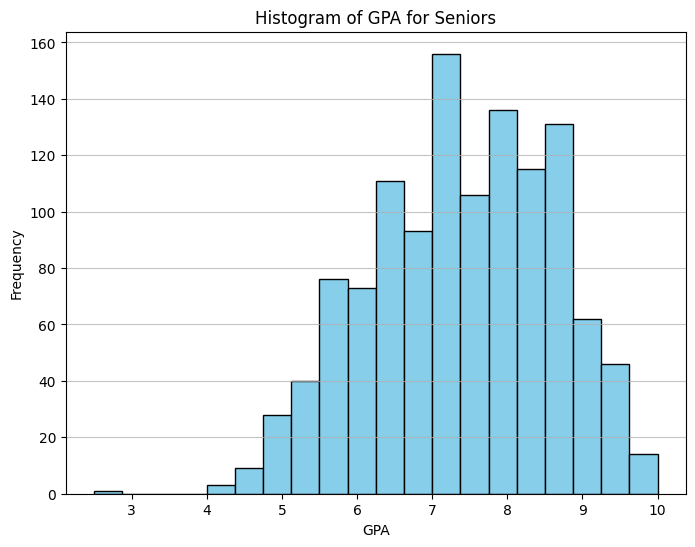

In [196]:
# Plot histogram of GPA data
plt.figure(figsize=(8, 6))
plt.hist(gpa_seniors_data, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of GPA for Seniors')
plt.xlabel('GPA')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

C:\Users\ethan\AppData\Local\Temp\ipykernel_23064\2786856023.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Node Weights')


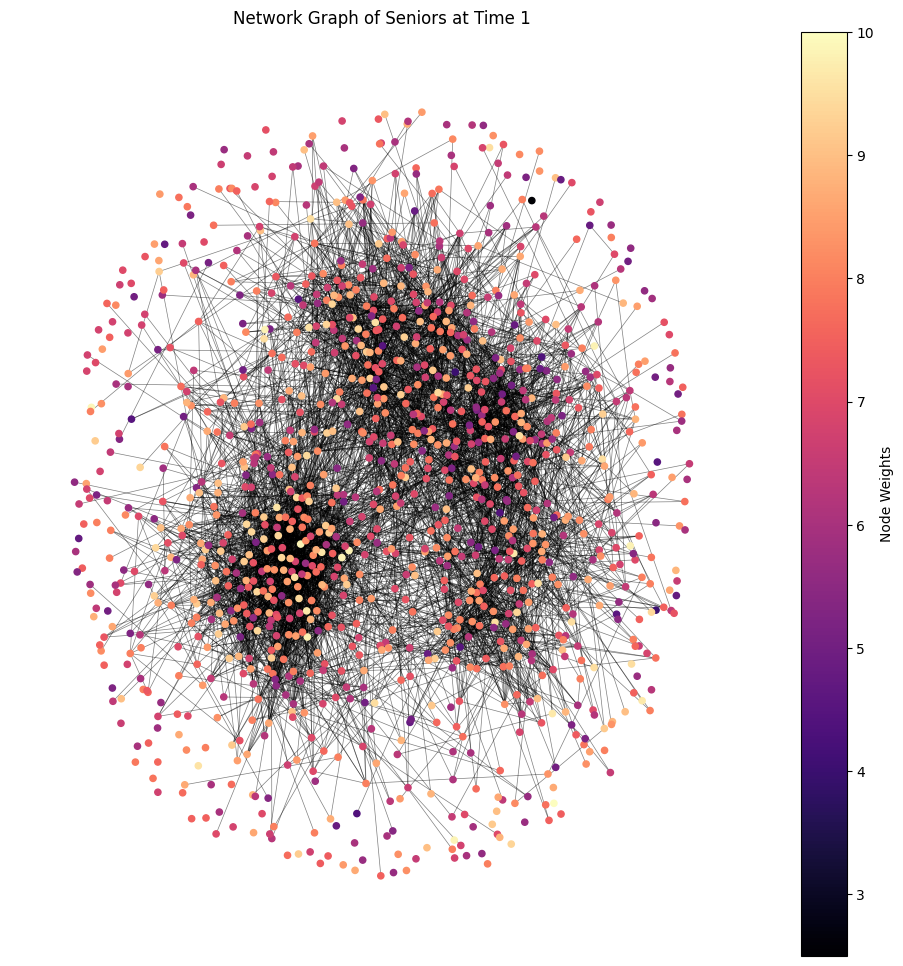

In [193]:
plot_network_from_matrix(networks_seniors_np['Sheet1'], plot_only_connected_nodes=False, title='Network Graph of Seniors at Time 1', node_weights=gpa_seniors_data.to_numpy())

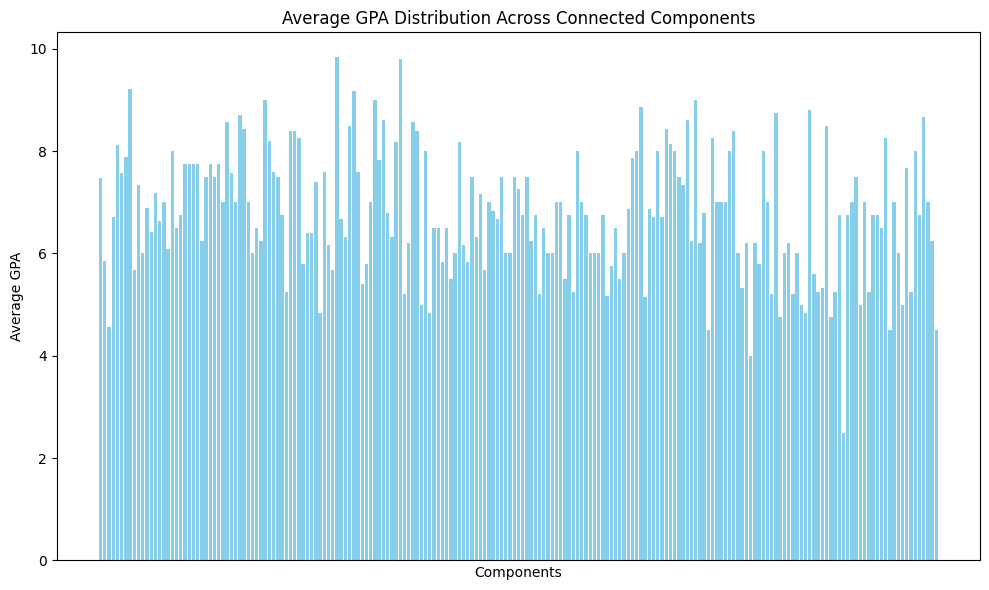

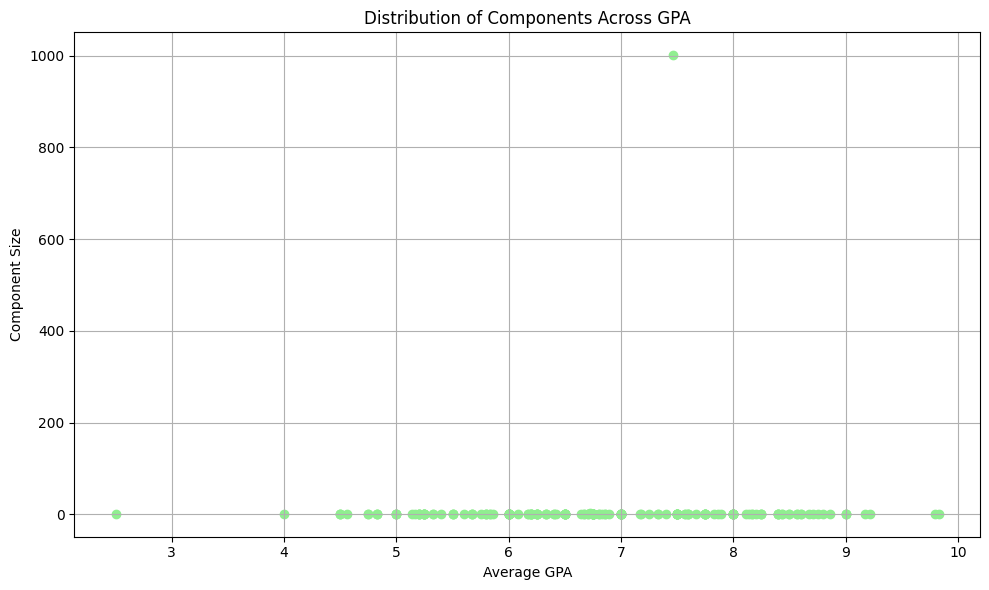

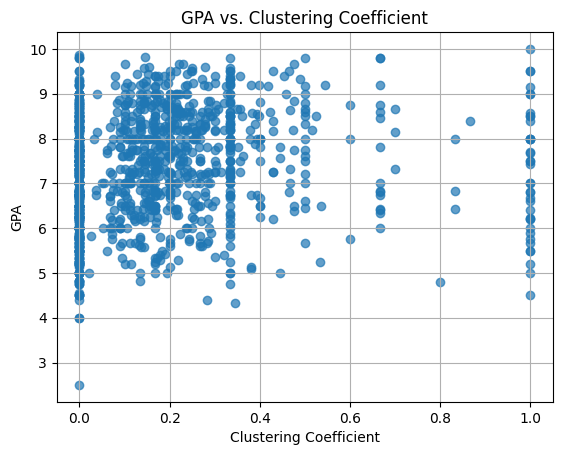

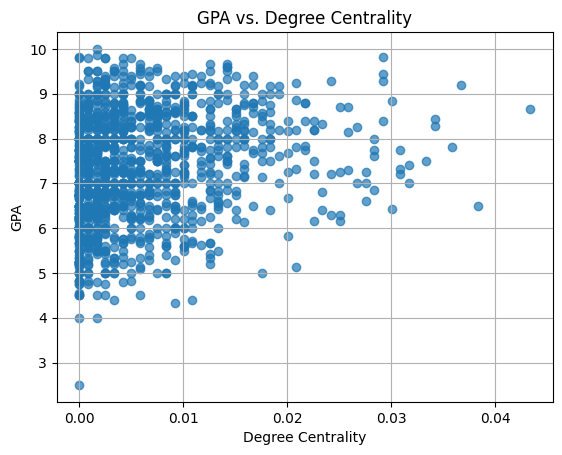

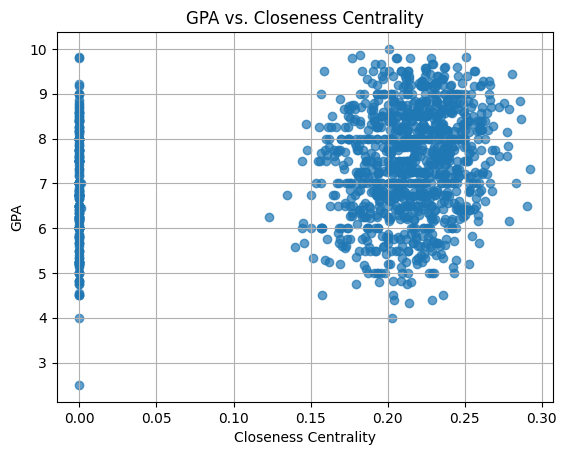

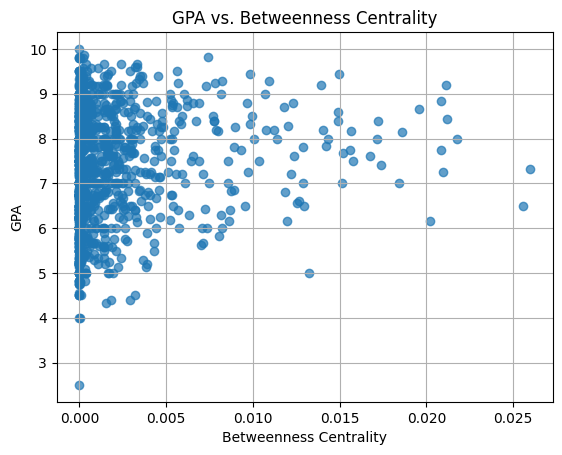

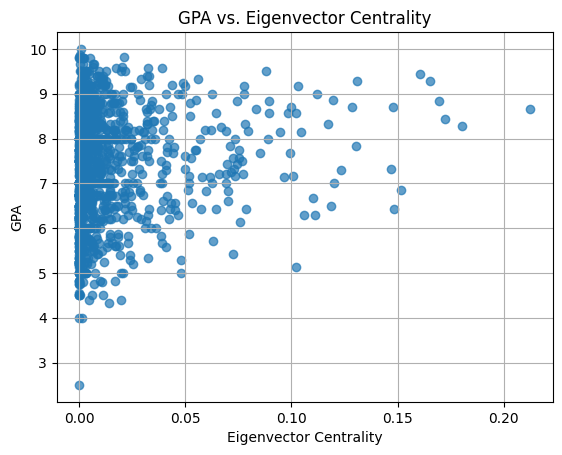

In [191]:
networks_seniors_report = network_analysis_with_gpa(networks_seniors_np['Sheet14'], gpa_seniors_data[0].to_numpy())